# **Sanity check**
### **05/26/2022**

In [1]:
import pandas as pd
import numpy as np
import re
import os
import time
import matplotlib.pyplot as plt
from glob import glob
import random
import sklearn
from sklearn.model_selection import GridSearchCV

In [2]:
def mahalanobis_transformation(feature_df, flag = "Train"):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    if flag == "Train":
        globals()['feature_mean'] = np.array(feature_df.mean()).reshape(-1, 1).T # 1 * p
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_df.shape[0]
        u, s, vh = np.linalg.svd(cov) # all real numbers
        # w, v = np.linalg.eig(cov) # generate complex numbers
        # theshold for pinv: 1e-15
        s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
        s_pinv_sqrt = np.array(np.zeros(feature_df.shape[1]))
        for i, item in enumerate(np.diag(s_pinv)):
            if item > 0:
                s_pinv_sqrt[i] = np.sqrt(item)
        globals()['sigma_pinv_sqrt'] = u @ np.diag(s_pinv_sqrt) @ u.T
        feature_df_whitened = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    else:
        feature_df_whitened = (feature_df - ones @ globals()['feature_mean']) @ globals()['sigma_pinv_sqrt']
    return feature_df_whitened

def my_SAVE(feature_df, label_df, flag = "Train", n_directions = 977):

    def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_centered.shape[0]
        return cov
    
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
        # whitening
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Train")
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df before post processing: {feature_df.shape}')
        # get slices
        slice_index_dict = {1: [], 2: [], 3: [], 4: [], 5: []}
        for i in np.arange(5):
            slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
            globals()["feature_df_" + str(i + 1)] = feature_df_whitened.loc[slice_index_dict[i + 1],:]
            globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
            # get sliced cov matrices
            globals()['cov_' + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])
        # concatenate 5 cov matrices, weighted by the proportion of classes
        globals()['weight_df'] = label_df["label"].value_counts() / label_df.shape[0]
        weighted_cov = pd.DataFrame(
            data = np.zeros((cov_1.shape[0], cov_1.shape[0])), 
            columns = np.arange(feature_df.shape[1], dtype = int), 
            index = globals()['cov_' + str(1)].index
        )
        for i in np.arange(5):
            print('-------------------------------------------------------------------')
            print(f'Class label {str(i + 1)}:')
            print('COV Mat:')
            print(globals()['cov_' + str(i + 1)])
            if feature_df.shape[1] == 2:
                u, s, vh = np.linalg.svd(globals()['cov_' + str(i + 1)])
                print(f'Eigen values of COV mat: {s}')
                print(f'Eigen values ratio of COV mat: {s[0] / s[1]:8.4f}')
                print(f'(1 - Eigen values of COV mat) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                print(f'(1 - Eigen values of COV mat)^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')
                u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                print(f'Eigen values of (I - COV mat): {s}')
                print(f'Eigen values ratio of (I - COV mat) : {s[0] / s[1]:8.4f}')
                print(f'(1 - Eigen values of (I - COV mat)) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                print(f'(1 - Eigen values of (I - COV mat))^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')

            u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
            print(f'(I - V) eigenvalues: {s}')
            u, s, vh = np.linalg.svd((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
            print(f'(I - V)^2 eigenvalues: {s}')
            weighted_cov += weight_df.loc[i + 1] * (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T
        u, s, vh = np.linalg.svd(weighted_cov)
        print('-------------------------------------------------------------------')
        print(f'Weighted sum of (I - V)^2 eigenvalues: {s}')
        print('-------------------------------------------------------------------')
        globals()['directions'] = vh[:,:n_directions]
        feature_df_reduced = feature_df_whitened @ directions
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Test")
        feature_df_reduced = feature_df_whitened @ globals()['directions']
    return feature_df_reduced, feature_df_whitened

def sliced_SAVE(feature_df, label_df, flag = "Train", n_directions = 977):
    from sliced import SlicedAverageVarianceEstimation
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
        # whitening
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Train")
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df before post processing: {feature_df.shape}')
        globals()['save'] = SlicedAverageVarianceEstimation(n_directions = n_directions, n_slices = 5)
        globals()['save'].fit(feature_df, label_df)
        globals()['directions'] = globals()['save'].directions_
        feature_df_reduced = globals()['save'].transform(feature_df_whitened)
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}')  
    else:
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Test")
        feature_df_reduced = globals()['save'].transform(feature_df_whitened)
        return feature_df_reduced, feature_df_whitened

def post_process(
    feature_df, 
    label_df, 
    flag = "Train", 
    method = None, 
    add_predictors = False, 
    n_directions = 977
):
    '''
    Implement sufficient dimension reduction methods. 
    SAVE
    Contour regression
    '''
    %xmode plain
    import pandas as pd
    import re
    import os
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    if method:
        feature_df_reduced, feature_df_whitened = method(
            feature_df = feature_df, 
            label_df = label_df, 
            flag = flag,
            n_directions = n_directions
        )
        feature_df_reduced = pd.DataFrame(feature_df_reduced)
        return feature_df_reduced, feature_df_whitened
    else:
        print("No method specified")
        pass


In [3]:
def sanity_check(size = 1000, core_dirs = 1, feature_df_flag = False, feature_df = None, core_distribution = np.random.uniform, redundant_dirs = 1, n_directions = 1, fig_output = True, **kwargs):
    if feature_df_flag == False:
        core_feature_df = pd.DataFrame(data = None)
        for i in np.arange(core_dirs):
            core_feature_df = pd.concat(
                [
                    core_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * 5)
                ], 
                axis = 1
            )
        core_coef = np.random.random(size = core_dirs) * 0.1
        y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
        y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
        redundant_feature_df = pd.DataFrame(data = None)
        for i in np.arange(redundant_dirs):
            redundant_feature_df = pd.concat(
                [
                    redundant_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * (np.random.randint(10) + 5))
                ], 
                axis = 1
            )

    if feature_df_flag == False:
        syncthetic_feature_df_train = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
    else:
        syncthetic_feature_df_train = feature_df
    syncthetic_label_df_train = pd.DataFrame(y_train_discrete, columns = ["label"])

    feature_df_reduced, feature_df_whitened = post_process(
        feature_df = syncthetic_feature_df_train, 
        label_df = syncthetic_label_df_train, 
        flag = "Train", 
        method = my_SAVE, 
        n_directions = n_directions
    )
    if fig_output:
        fig = plt.figure(figsize = (4,4), dpi = 270)
        ax = fig.add_subplot(projection = '3d')
        ax.scatter(
            feature_df_whitened.iloc[:,0], 
            feature_df_whitened.iloc[:,1], 
            y_train_discrete.reshape(-1, 1), 
            cmap = "inferno", 
            s = 4, 
            linewidths = 0, 
            edgecolors = None, 
            c = y_train_discrete.reshape(-1, 1))
        ax.set_xlabel("core_x1")
        ax.set_ylabel("redundant_x1")
        ax.set_zlabel("y")
        ax.set_title("Core features: " + str(core_dirs) + " Redundant features: " + str(redundant_dirs))
        plt.show()
        plt.figure(figsize = (4, 3), dpi = 270)
        plt.scatter(core_feature_df.iloc[:,0], y_train_discrete, cmap = "inferno", c = y_train_discrete.reshape(-1, 1))
        plt.xlabel("core_x1")
        plt.ylabel("y")
        plt.title("Sectional View")
        plt.show()
    print('-------------------------------------------------------------------')
    print(f'Directions: \n{directions}')
    return feature_df_reduced, feature_df_whitened, syncthetic_label_df_train


Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (1000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.955166  0.122409  0.198094 -0.038864  0.043254  0.085832  0.049080   
1  0.122409  0.901998 -0.023516  0.042870 -0.137573  0.047346  0.054833   
2  0.198094 -0.023516  0.972209  0.018354  0.056518 -0.037886  0.032982   
3 -0.038864  0.042870  0.018354  1.003328  0.001544  0.066431 -0.095349   
4  0.043254 -0.137573  0.056518  0.001544  0.953590  0.012550 -0.002592   
5  0.085832  0.047346 -0.037886  0.066431  0.012550  0.981567  0.075452   
6  0.049080  0.054833  0.032982 -0.095349 -0.002592  0.075452  1.071330   
7 -0.002923 -0.017137  0.013497  0.057478  0.027543 -0.005875  0.124760   
8  0.100892 -0.039069  0.003583 -0.054123  0.029768 -0.039183  0.032069   
9  

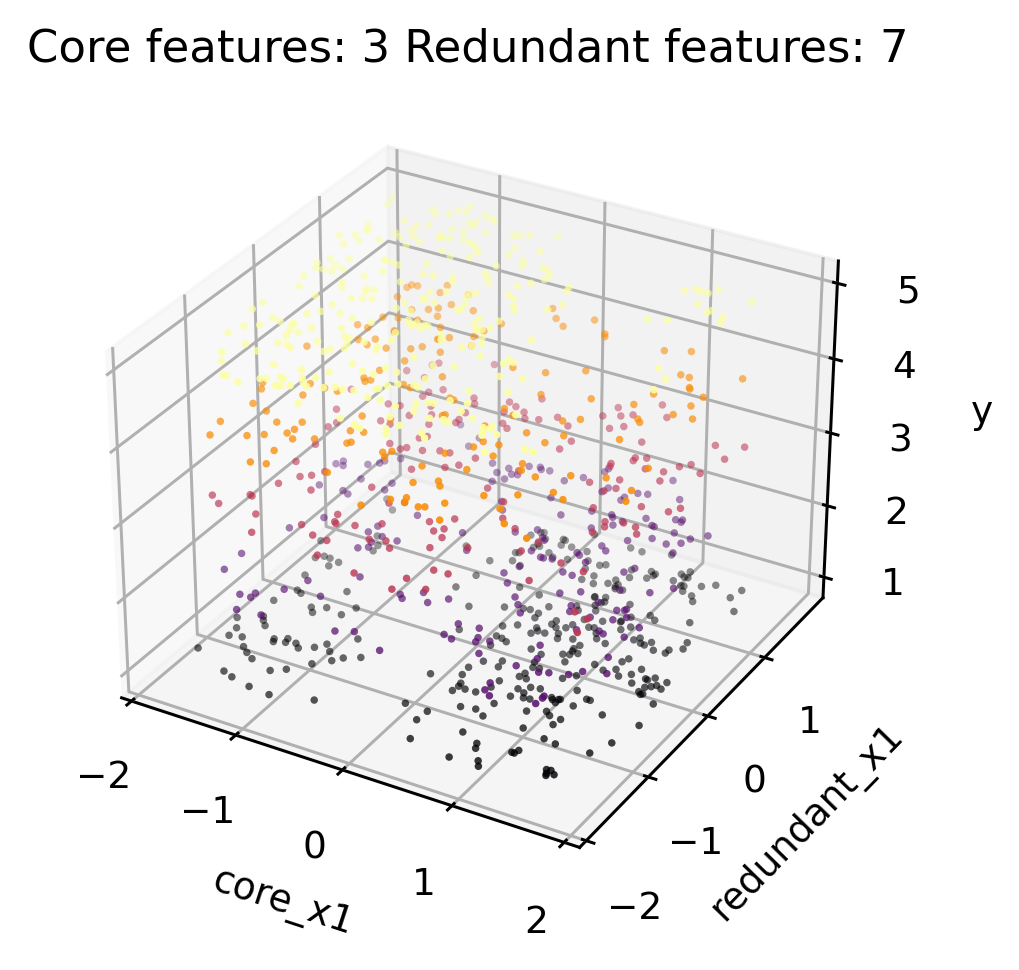

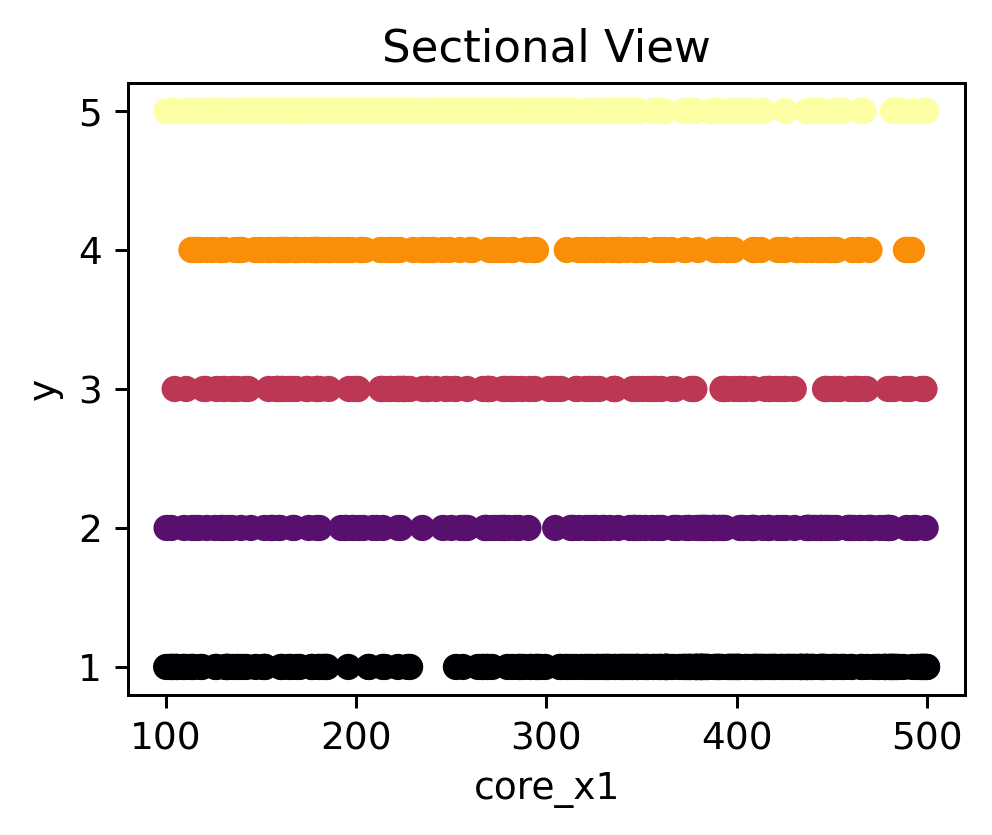

-------------------------------------------------------------------
Directions: 
[[-0.87296537 -0.1993206  -0.37938267]
 [ 0.43453792 -0.18671658 -0.73825428]
 [-0.01868926 -0.49822589  0.16021419]
 [-0.1508469   0.68350348 -0.04982028]
 [ 0.08819937 -0.00446504 -0.12355869]
 [-0.05009142 -0.37436406  0.28027748]
 [ 0.10957333 -0.05552176  0.21788722]
 [-0.01617885  0.22095376 -0.10475336]
 [-0.05243493  0.12733188  0.34712696]
 [-0.02642763  0.04143861 -0.10065444]]


In [4]:
feature_df_reduced, feature_df_whitened, label_df = sanity_check(core_dirs = 3, redundant_dirs = 7, n_directions = 3, low = 20, high = 100)

In [5]:
basis = directions[:3,:]
print(np.linalg.matrix_rank(basis))
basis

3


array([[-0.87296537, -0.1993206 , -0.37938267],
       [ 0.43453792, -0.18671658, -0.73825428],
       [-0.01868926, -0.49822589,  0.16021419]])

#### Logistic Regression

In [17]:
def my_lr(feature_df_train, feature_df_test, label_df_train, label_df_test):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, accuracy_score

    lr_params_grid = {
        'C': [1e-5, 0.0001, 0.001, 0.01, 0.1, 0.5, 1,3,5,10], 
        'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
        'penalty': ['elasticnet'],  
        'solver': ['saga'], 
        'random_state': [42], 
        'max_iter': [200, 400, 600, 800, 1000, 2000], 
        'verbose': [0], 
        'n_jobs': [-1], 
        'l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1]
    }

    gs_lr = GridSearchCV(
        estimator = LogisticRegression(), 
        param_grid = lr_params_grid, 
        cv = 5, 
        scoring = 'accuracy', 
        verbose = 0, 
        n_jobs = -1
    )
    gs_lr.fit(feature_df_train, np.array(label_df_train).ravel())
    best_lr = gs_lr.best_estimator_
    lr_pred = best_lr.predict(feature_df_test)
    lr_f1 = f1_score(y_true = label_df_test, y_pred = lr_pred, average = 'macro')
    lr_accu = accuracy_score(y_true = label_df_test, y_pred = lr_pred)
    print('Best params: ')
    print(gs_lr.best_params_)
    print(f'Accuracy: {lr_accu:8.4f}\nF1-score: {lr_f1:8.4f}')
    print('-------------------------------------------------------------------')
    return lr_f1, lr_accu

#### Learning curve with n_directions

In [27]:
def plot_learning_curve(n_directions_list, f1_score_list, accu_score_list, baseline_f1, baseline_accu, n_relevant_feature, n_irrelevant_feature, metric_name, x_name, title, x_scale = "linear", save = False, filepath = "", filename = ""):
    '''
    Input: x-axis (e.g. PCA directions kept / n_estimators / max_depth)
           metric_name for y-axis (e.g. misclassification error / crossentropy error / accuracy / f1 score)
           title for this axis
           training + validation score in list
           default in linear scale
           default no saving files, if save is True, then have to specify filename and file path
    Output: inline display of the learning curve
    '''
    import pandas as pd
    import numpy as np  
    import matplotlib
    from matplotlib import pyplot as plt
    from matplotlib import cm
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    fig,ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 320)
    ax.plot(n_directions_list, f1_score_list, 'o-', label = "F1 score", linewidth = 2)
    ax.plot(n_directions_list, accu_score_list, 'o-', label = "Accuracy score", linewidth = 2)
    ax.axhline(y = baseline_f1, label = "Baseline F1", linestyle = '--', linewidth = 2, c = [255 / 255, 107 / 255, 107 / 255], alpha = 0.7)
    ax.axhline(y = baseline_accu, label = "Baseline Accuracy", linestyle = '--', linewidth = 2, c = [165 / 255, 190 / 255, 204 / 255], alpha = 0.7)
    ax.axvline(x = n_relevant_feature, alpha = 0.4, c = np.array(221, 221, 221) / 255, linewidth = 6)
    ax.axvline(x = n_irrelevant_feature, alpha = 0.4, c = np.array(221, 221, 221) / 255, linewidth = 6)
    ax.legend()
    ax.set_xscale(x_scale)
    ax.set_title('Learning Curve: ' + title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(metric_name)
    plt.show()
    if save:
        fig.savefig(filepath + filename + ".png", format = "png")
    pass

In [22]:
# generate feature_df for reuse
def generate_synthetic_data(core_dirs = 3, redundant_dirs = 7, size = 2500, test_size = 0.2, core_distribution = np.random.uniform):
    import pandas as pd
    import numpy as np
    import re
    import os
    import random
    from sklearn.model_selection import train_test_split

    core_feature_df = pd.DataFrame(data = None)
    for i in np.arange(core_dirs):
        core_feature_df = pd.concat(
            [
                core_feature_df, 
                pd.Series(core_distribution(size = size, low = 20, high = 100) * (np.random.randint(10) + 5))
            ], 
            axis = 1
        )
    core_coef = np.random.random(size = core_dirs) * 0.1
    y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
    y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
    redundant_feature_df = pd.DataFrame(data = None)
    for i in np.arange(redundant_dirs):
        redundant_feature_df = pd.concat(
            [
                redundant_feature_df, 
                pd.Series(core_distribution(size = size, low = 20, high = 100) * (np.random.randint(10) + 5))
            ], 
            axis = 1
        )
    synthetic_feature_df = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
    synthetic_label_df = pd.DataFrame(y_train_discrete, columns = ["label"])
    synthetic_feature_df_train, synthetic_feature_df_test, synthetic_label_df_train, synthetic_label_df_test = train_test_split(
        synthetic_feature_df, synthetic_label_df, 
        test_size = test_size, 
        shuffle = True, 
        random_state = 42
    )
    return synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test

synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test = generate_synthetic_data(core_dirs = 3, redundant_dirs = 7, size = 4000, test_size = 0.2, core_distribution = np.random.uniform)

In [23]:
def lr_learning_curve(synthetic_feature_df_train, synthetic_label_df_train, synthetic_feature_df_test, synthetic_label_df_test, method = my_SAVE):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, accuracy_score

    n_directions_list = list(np.arange(1, synthetic_feature_df_train.shape[1] + 1, dtype = int))
    f1_list = []
    accu_list = []

    for n_direction in n_directions_list:
        print(f'n_directions: {n_direction}')
        globals()['feature_df_reduced_' + str(n_direction) + "_train"], synthetic_feature_df_train_whitened = post_process(
            synthetic_feature_df_train, 
            synthetic_label_df_train, 
            flag = "Train", 
            method = method, 
            add_predictors = False, 
            n_directions = n_direction
        )
        globals()['feature_df_reduced_' + str(n_direction) + "_test"], synthetic_feature_df_test_whitened = post_process(
            synthetic_feature_df_test, 
            synthetic_label_df_test, 
            flag = "Test", 
            method = method, 
            add_predictors = False, 
            n_directions = n_direction
        )
        curr_test_f1, curr_test_accu = my_lr(
            feature_df_train = globals()['feature_df_reduced_' + str(n_direction) + "_train"], 
            feature_df_test = globals()['feature_df_reduced_' + str(n_direction) + "_test"], 
            label_df_train = synthetic_label_df_train, 
            label_df_test = synthetic_label_df_test
        )
        f1_list.append(curr_test_f1)
        accu_list.append(curr_test_accu)

    # train w/ original features -> syncthetic_feature_df -> whitened
    baseline_test_f1, baseline_test_accu = my_lr(
            feature_df_train = synthetic_feature_df_train_whitened, 
            feature_df_test = synthetic_feature_df_test_whitened, 
            label_df_train = synthetic_label_df_train, 
            label_df_test = synthetic_label_df_test
    )
    return f1_list, accu_list, baseline_test_f1, baseline_test_accu, n_directions_list

f1_list, accu_list, baseline_f1, baseline_accu, n_directions_list = lr_learning_curve(
    synthetic_feature_df_train, 
    synthetic_label_df_train, 
    synthetic_feature_df_test, 
    synthetic_label_df_test
)


n_directions: 1
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.003234  0.000983  0.037519 -0.046925  0.987211  0.028023   
6  0.008258  0.008190  0.054110 -0.013040 -0.060276  0.028023  0.964066   
7  0.053420 -0.017209 -0.001137  0.004518 -0.015504 -0.016406  0.041438   
8 -0.025948  0.028724  0.031109 -0.054559 -0.038188  0.042494 

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.001, 'l1_ratio': 0.0001, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01, 'verbose': 0}
Accuracy:   0.2787
F1-score:   0.1050
-------------------------------------------------------------------
n_directions: 2
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.2787
F1-score:   0.1308
-------------------------------------------------------------------
n_directions: 3
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.5, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01, 'verbose': 0}
Accuracy:   0.3100
F1-score:   0.1602
-------------------------------------------------------------------
n_directions: 4
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.00323

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.5, 'l1_ratio': 0.5, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01, 'verbose': 0}
Accuracy:   0.3100
F1-score:   0.1600
-------------------------------------------------------------------
n_directions: 5
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.003

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.5, 'l1_ratio': 0.5, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01, 'verbose': 0}
Accuracy:   0.3300
F1-score:   0.1711
-------------------------------------------------------------------
n_directions: 6
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.003

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.1, 'l1_ratio': 0.8, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01, 'verbose': 0}
Accuracy:   0.3337
F1-score:   0.1731
-------------------------------------------------------------------
n_directions: 7
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.003

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.01, 'l1_ratio': 0.2, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3362
F1-score:   0.1741
-------------------------------------------------------------------
n_directions: 8
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.01, 'l1_ratio': 0.2, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3387
F1-score:   0.1755
-------------------------------------------------------------------
n_directions: 9
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.01, 'l1_ratio': 0.2, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3375
F1-score:   0.1748
-------------------------------------------------------------------
n_directions: 10
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (3200, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.954081 -0.007671  0.056451  0.040175 -0.016414 -0.001990  0.008258   
1 -0.007671  1.058414  0.077554 -0.016659  0.024070 -0.003234  0.008190   
2  0.056451  0.077554  0.870025 -0.010392  0.007267  0.000983  0.054110   
3  0.040175 -0.016659 -0.010392  1.017514  0.031580  0.037519 -0.013040   
4 -0.016414  0.024070  0.007267  0.031580  0.988169 -0.046925 -0.060276   
5 -0.001990 -0.

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.01, 'l1_ratio': 0.2, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3362
F1-score:   0.1742
-------------------------------------------------------------------


/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

Best params: 
{'C': 0.01, 'l1_ratio': 0.5, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01, 'verbose': 0}
Accuracy:   0.3438
F1-score:   0.1777
-------------------------------------------------------------------


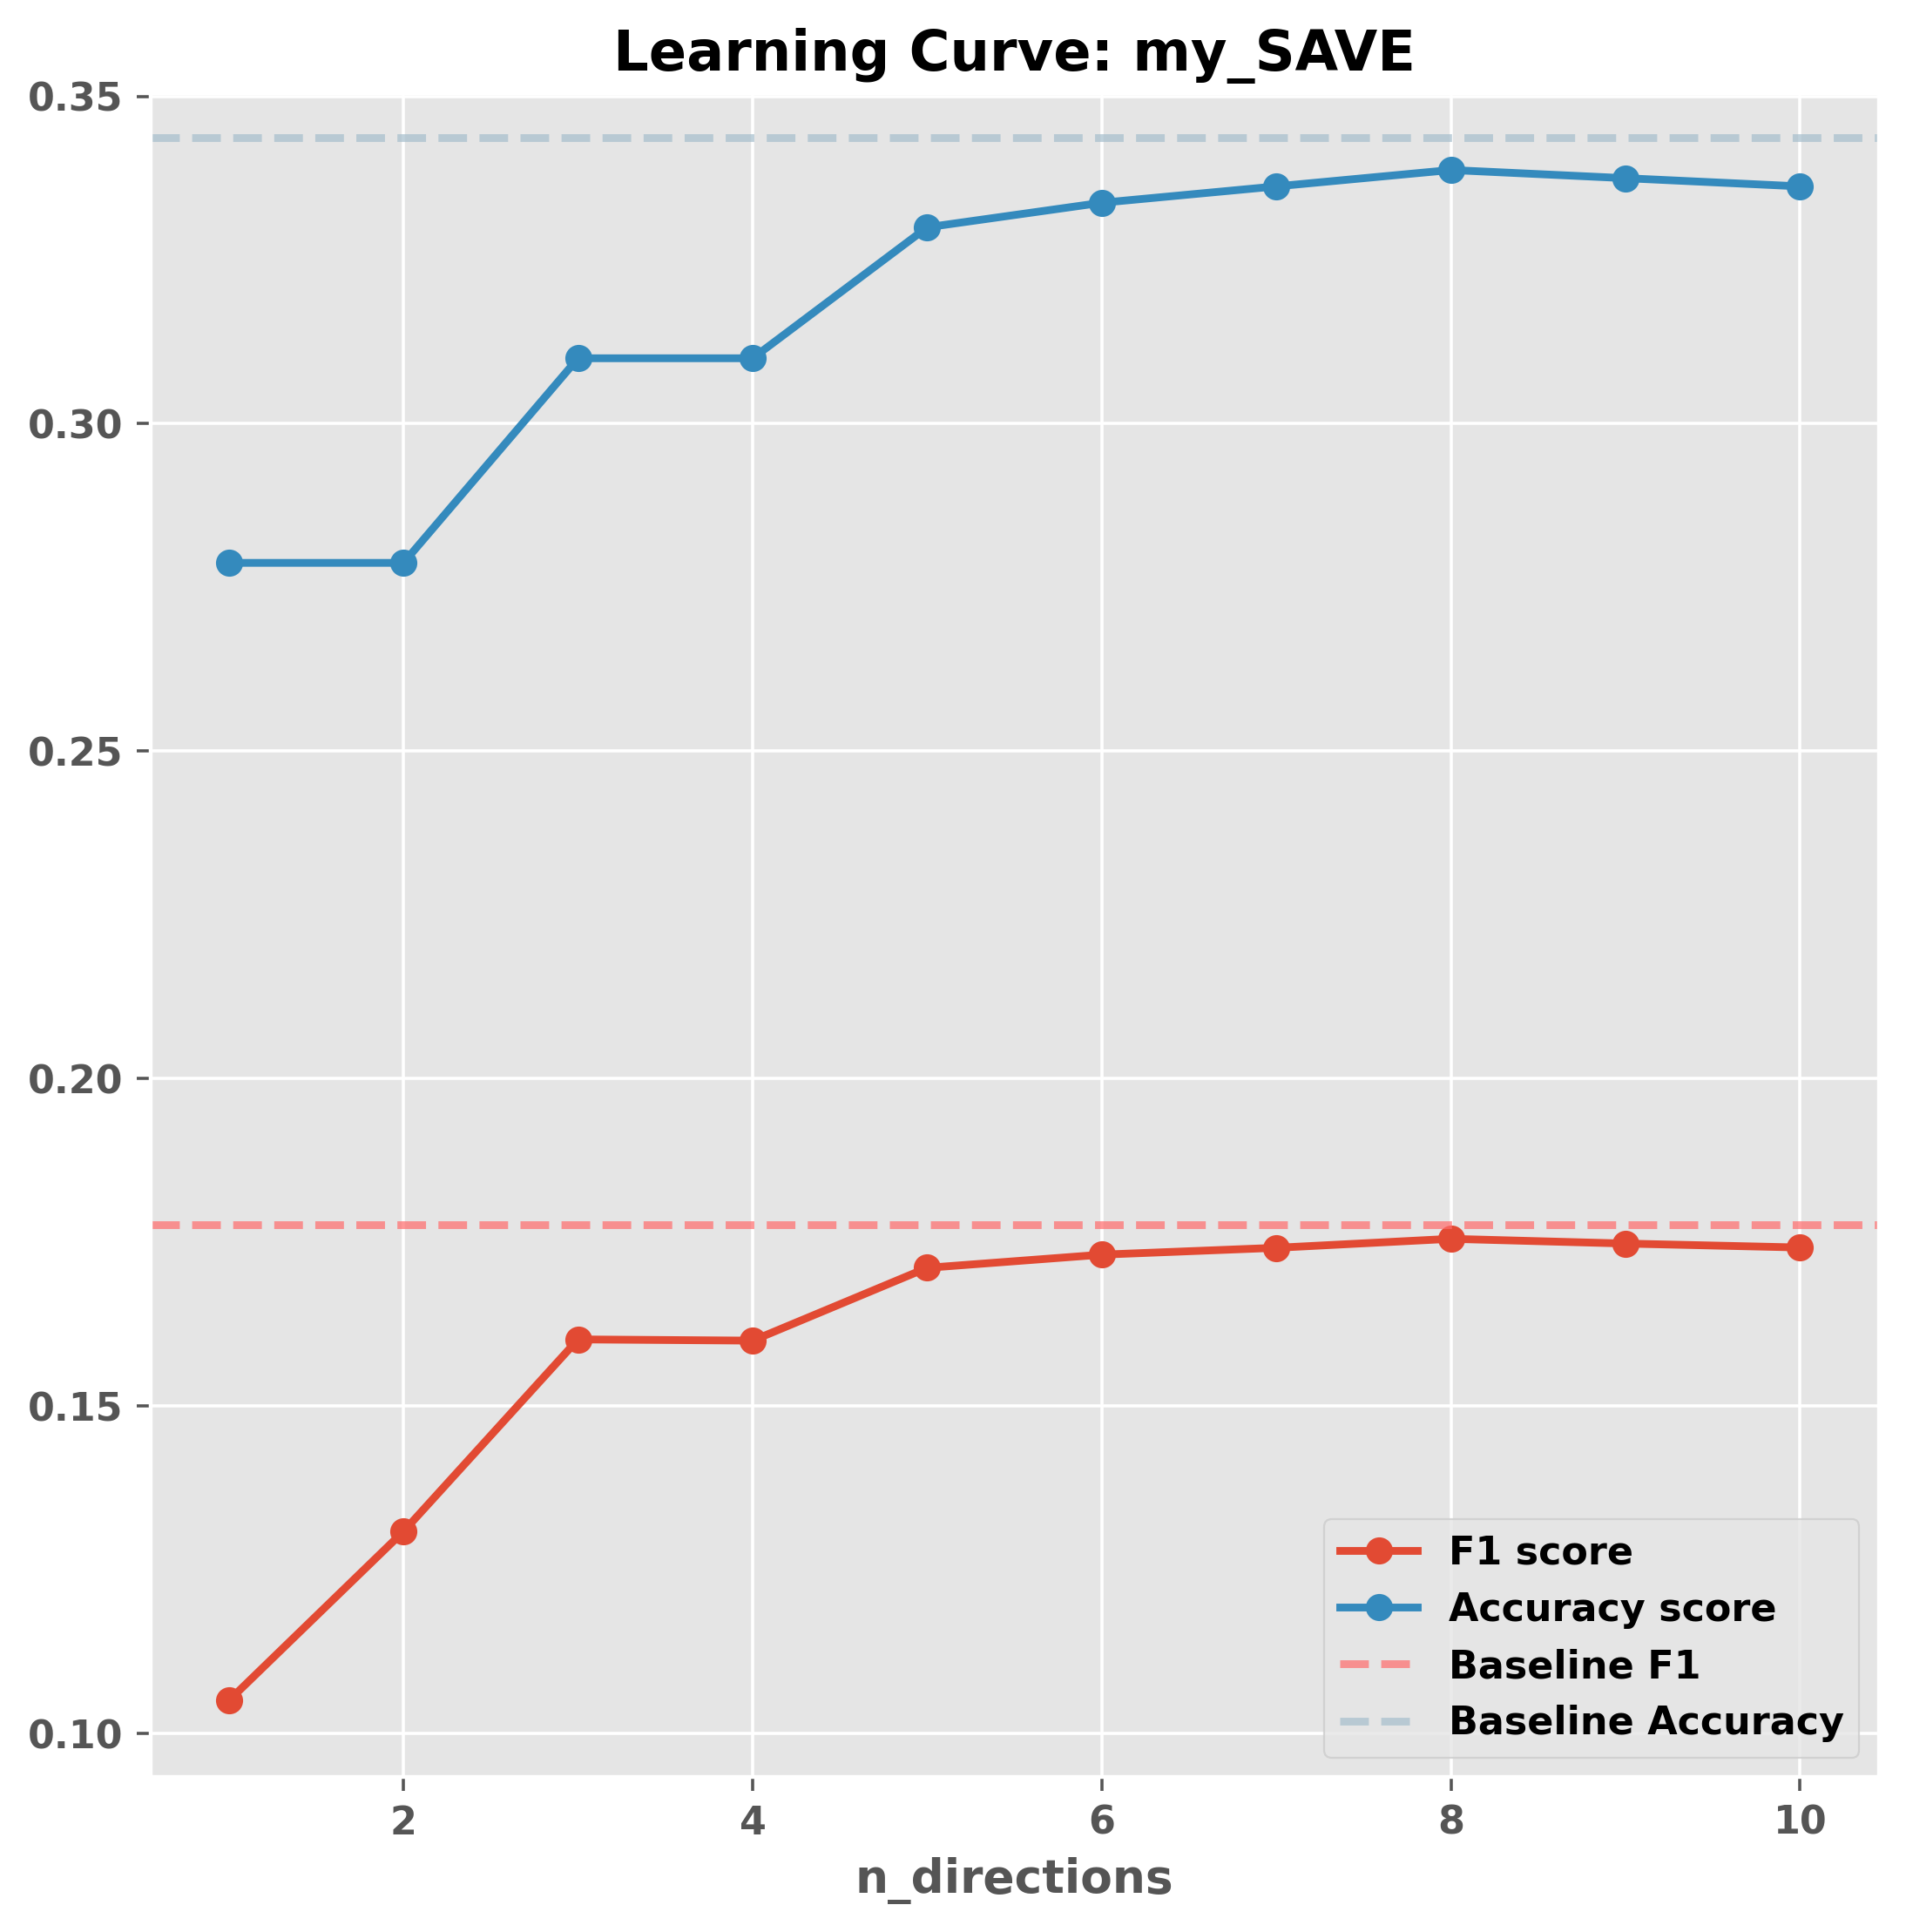

In [24]:
plot_learning_curve(
    n_directions_list = n_directions_list, 
    f1_score_list = f1_list, 
    accu_score_list = accu_list, 
    baseline_f1 = baseline_f1, 
    baseline_accu = baseline_accu,
    n_relevant_feature = 3,
    metric_name = "", 
    x_name = "n_directions", 
    title = "my_SAVE"
)

In [25]:
pd.DataFrame(mahalanobis_transformation(synthetic_feature_df_train)).cov()

,0,1,2,3,4,5,6,7,8,9
0,1.000313e+00,-6.594010e-17,6.760595e-17,-4.275695e-17,3.664881e-17,1.429859e-17,1.138334e-17,-6.552363e-17,6.663420e-18,-2.221140e-18
1,-6.594010e-17,1.000313e+00,-2.933814e-16,7.773991e-17,-4.109109e-17,-8.773504e-17,3.056844e-16,3.775938e-17,-1.371554e-16,1.082806e-16
2,6.760595e-17,-2.933814e-16,1.000313e+00,5.530639e-16,8.801268e-16,-6.896640e-16,-1.203580e-16,1.956686e-16,-6.294156e-16,-9.345447e-16
3,-4.275695e-17,7.773991e-17,5.530639e-16,1.000313e+00,-3.581589e-16,8.662447e-17,4.531126e-16,-5.902680e-16,3.090161e-16,2.143400e-16
4,3.664881e-17,-4.109109e-17,8.801268e-16,-3.581589e-16,1.000313e+00,1.657526e-16,3.459773e-16,1.353230e-15,4.009158e-16,-3.478861e-16
5,1.429859e-17,-8.773504e-17,-6.896640e-16,8.662447e-17,1.657526e-16,1.000313e+00,-7.196494e-16,-2.251681e-16,-3.514954e-16,8.534731e-16
6,1.138334e-17,3.056844e-16,-1.203580e-16,4.531126e-16,3.459773e-16,-7.196494e-16,1.000313e+00,-1.259386e-15,-7.111813e-16,-3.337263e-16
7,-6.552363e-17,3.775938e-17,1.956686e-16,-5.902680e-16,1.353230e-15,-2.251681e-16,-1.259386e-15,1.000313e+00,-3.037409e-16,1.726936e-16
8,6.663420e-18,-1.371554e-16,-6.294156e-16,3.090161e-16,4.009158e-16,-3.514954e-16,-7.111813e-16,-3.037409e-16,1.000313e+00,-1.915733e-16
9,-2.221140e-18,1.082806e-16,-9.345447e-16,2.143400e-16,-3.478861e-16,8.534731e-16,-3.337263e-16,1.726936e-16,-1.915733e-16,1.000313e+00


In [26]:
pd.DataFrame(mahalanobis_transformation(synthetic_feature_df_test)).cov()

,0,1,2,3,4,5,6,7,8,9
0,1.001252e+00,-3.401534e-16,-1.934206e-16,5.780385e-17,4.668773e-17,-1.044916e-16,5.113418e-17,-1.689651e-16,-1.800812e-16,-5.335740e-17
1,-3.401534e-16,1.001252e+00,4.157431e-16,-7.269946e-16,4.602076e-16,1.734116e-16,-1.111613e-16,-4.169937e-16,1.458436e-15,-2.134296e-16
2,-1.934206e-16,4.157431e-16,1.001252e+00,-6.269495e-16,2.089832e-16,-9.782190e-17,5.824850e-16,2.678986e-16,4.624308e-16,-1.089380e-16
3,5.780385e-17,-7.269946e-16,-6.269495e-16,1.001252e+00,6.657170e-16,4.040712e-16,4.446450e-18,-6.191682e-16,5.913779e-16,-3.835063e-16
4,4.668773e-17,4.602076e-16,2.089832e-16,6.657170e-16,1.001252e+00,3.523812e-16,-2.612289e-16,6.658559e-16,-3.273699e-16,-1.778580e-16
5,-1.044916e-16,1.734116e-16,-9.782190e-17,4.040712e-16,3.523812e-16,1.001252e+00,-3.723902e-17,-9.337545e-17,-2.234341e-16,-7.772951e-16
6,5.113418e-17,-1.111613e-16,5.824850e-16,4.446450e-18,-2.612289e-16,-3.723902e-17,1.001252e+00,-2.745683e-16,3.912876e-16,2.256573e-16
7,-1.689651e-16,-4.169937e-16,2.678986e-16,-6.191682e-16,6.658559e-16,-9.337545e-17,-2.745683e-16,1.001252e+00,-1.156077e-16,-3.223676e-17
8,-1.800812e-16,1.458436e-15,4.624308e-16,5.913779e-16,-3.273699e-16,-2.234341e-16,3.912876e-16,-1.156077e-16,1.001252e+00,-5.002256e-16
9,-5.335740e-17,-2.134296e-16,-1.089380e-16,-3.835063e-16,-1.778580e-16,-7.772951e-16,2.256573e-16,-3.223676e-17,-5.002256e-16,1.001252e+00
